In [5]:
# Usual suspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pandas as pd
sys.path.insert(1, '../muograph')

%reload_ext autoreload
%autoreload 2

# **Principal Component Analysis**

We will now apply a **PCA** on all the available **voxel-wise information** we have, and see which **features** are the most relevant to **material classification**.

## **1 - Get voxels data set**

First, let's **collect** the **voxel-wise data** for the materials at study

In [6]:
materials_names = ('Aluminum', 'Lead', 'Glass', 'Uranium', 'Iron')

In [7]:
input_dir = "../data/voxel_data/"

In [9]:
from analysis.material import Material
from analysis.voxel import Voxel

dfs = []

for material_name in materials_names:

    material = Material(
        name = material_name, 
        output_dir = "None", 
        input_file = input_dir + material_name + ".pickle")
    
    print(material.name)
    
    data = {
        "dtheta_mean": np.concatenate([[vox.dtheta_params["mean"] for vox in material.voxels]]), 
        "dtheta_std": np.concatenate([[vox.dtheta_params["std"] for vox in material.voxels]] ), 
        "n_poca": np.concatenate([[vox.n_poca for vox in material.voxels]] ), 
        "material": np.concatenate([[vox.element.name for vox in material.voxels]] ), 
        "asr_std": np.concatenate([[vox.asr_params["std"] for vox in material.voxels]] ), 
        "asr_mean": np.concatenate([[vox.asr_params["mean"] for vox in material.voxels]] ), 
        "asr_q25": np.concatenate([[vox.asr_params["q25"] for vox in material.voxels]]), 
        "asr_q50": np.concatenate([[vox.asr_params["q50"] for vox in material.voxels]] ), 
        "asr_q75": np.concatenate([[vox.asr_params["q75"] for vox in material.voxels]] ),
        "bca_std": np.concatenate([[vox.bca_params["std"] for vox in material.voxels]]),
        "bca_mean": np.concatenate([[vox.bca_params["mean"] for vox in material.voxels]]),
        "bca_q25": np.concatenate([[vox.bca_params["q25"] for vox in material.voxels]]), 
        "bca_q5": np.concatenate([[vox.bca_params["q5"] for vox in material.voxels]]),
        "bca_q75": np.concatenate([[vox.bca_params["q75"] for vox in material.voxels]]),
        "x_index": np.concatenate([[vox.index[0] for vox in material.voxels]]),
        "y_index": np.concatenate([[vox.index[1] for vox in material.voxels]]), 
        "z_index": np.concatenate([[vox.index[2] for vox in material.voxels]]),
        "lumuosity": np.concatenate([[vox.relative_lumuosity for vox in material.voxels]])
    }

    dfs.append(pd.DataFrame(data))

    del material

df = pd.concat(dfs, ignore_index = True)

Aluminum
Lead
Glass
Uranium
Iron


/tmp/ipykernel_24968/3535188714.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pd.plotting.scatter_matrix(frame = df.drop(columns = [


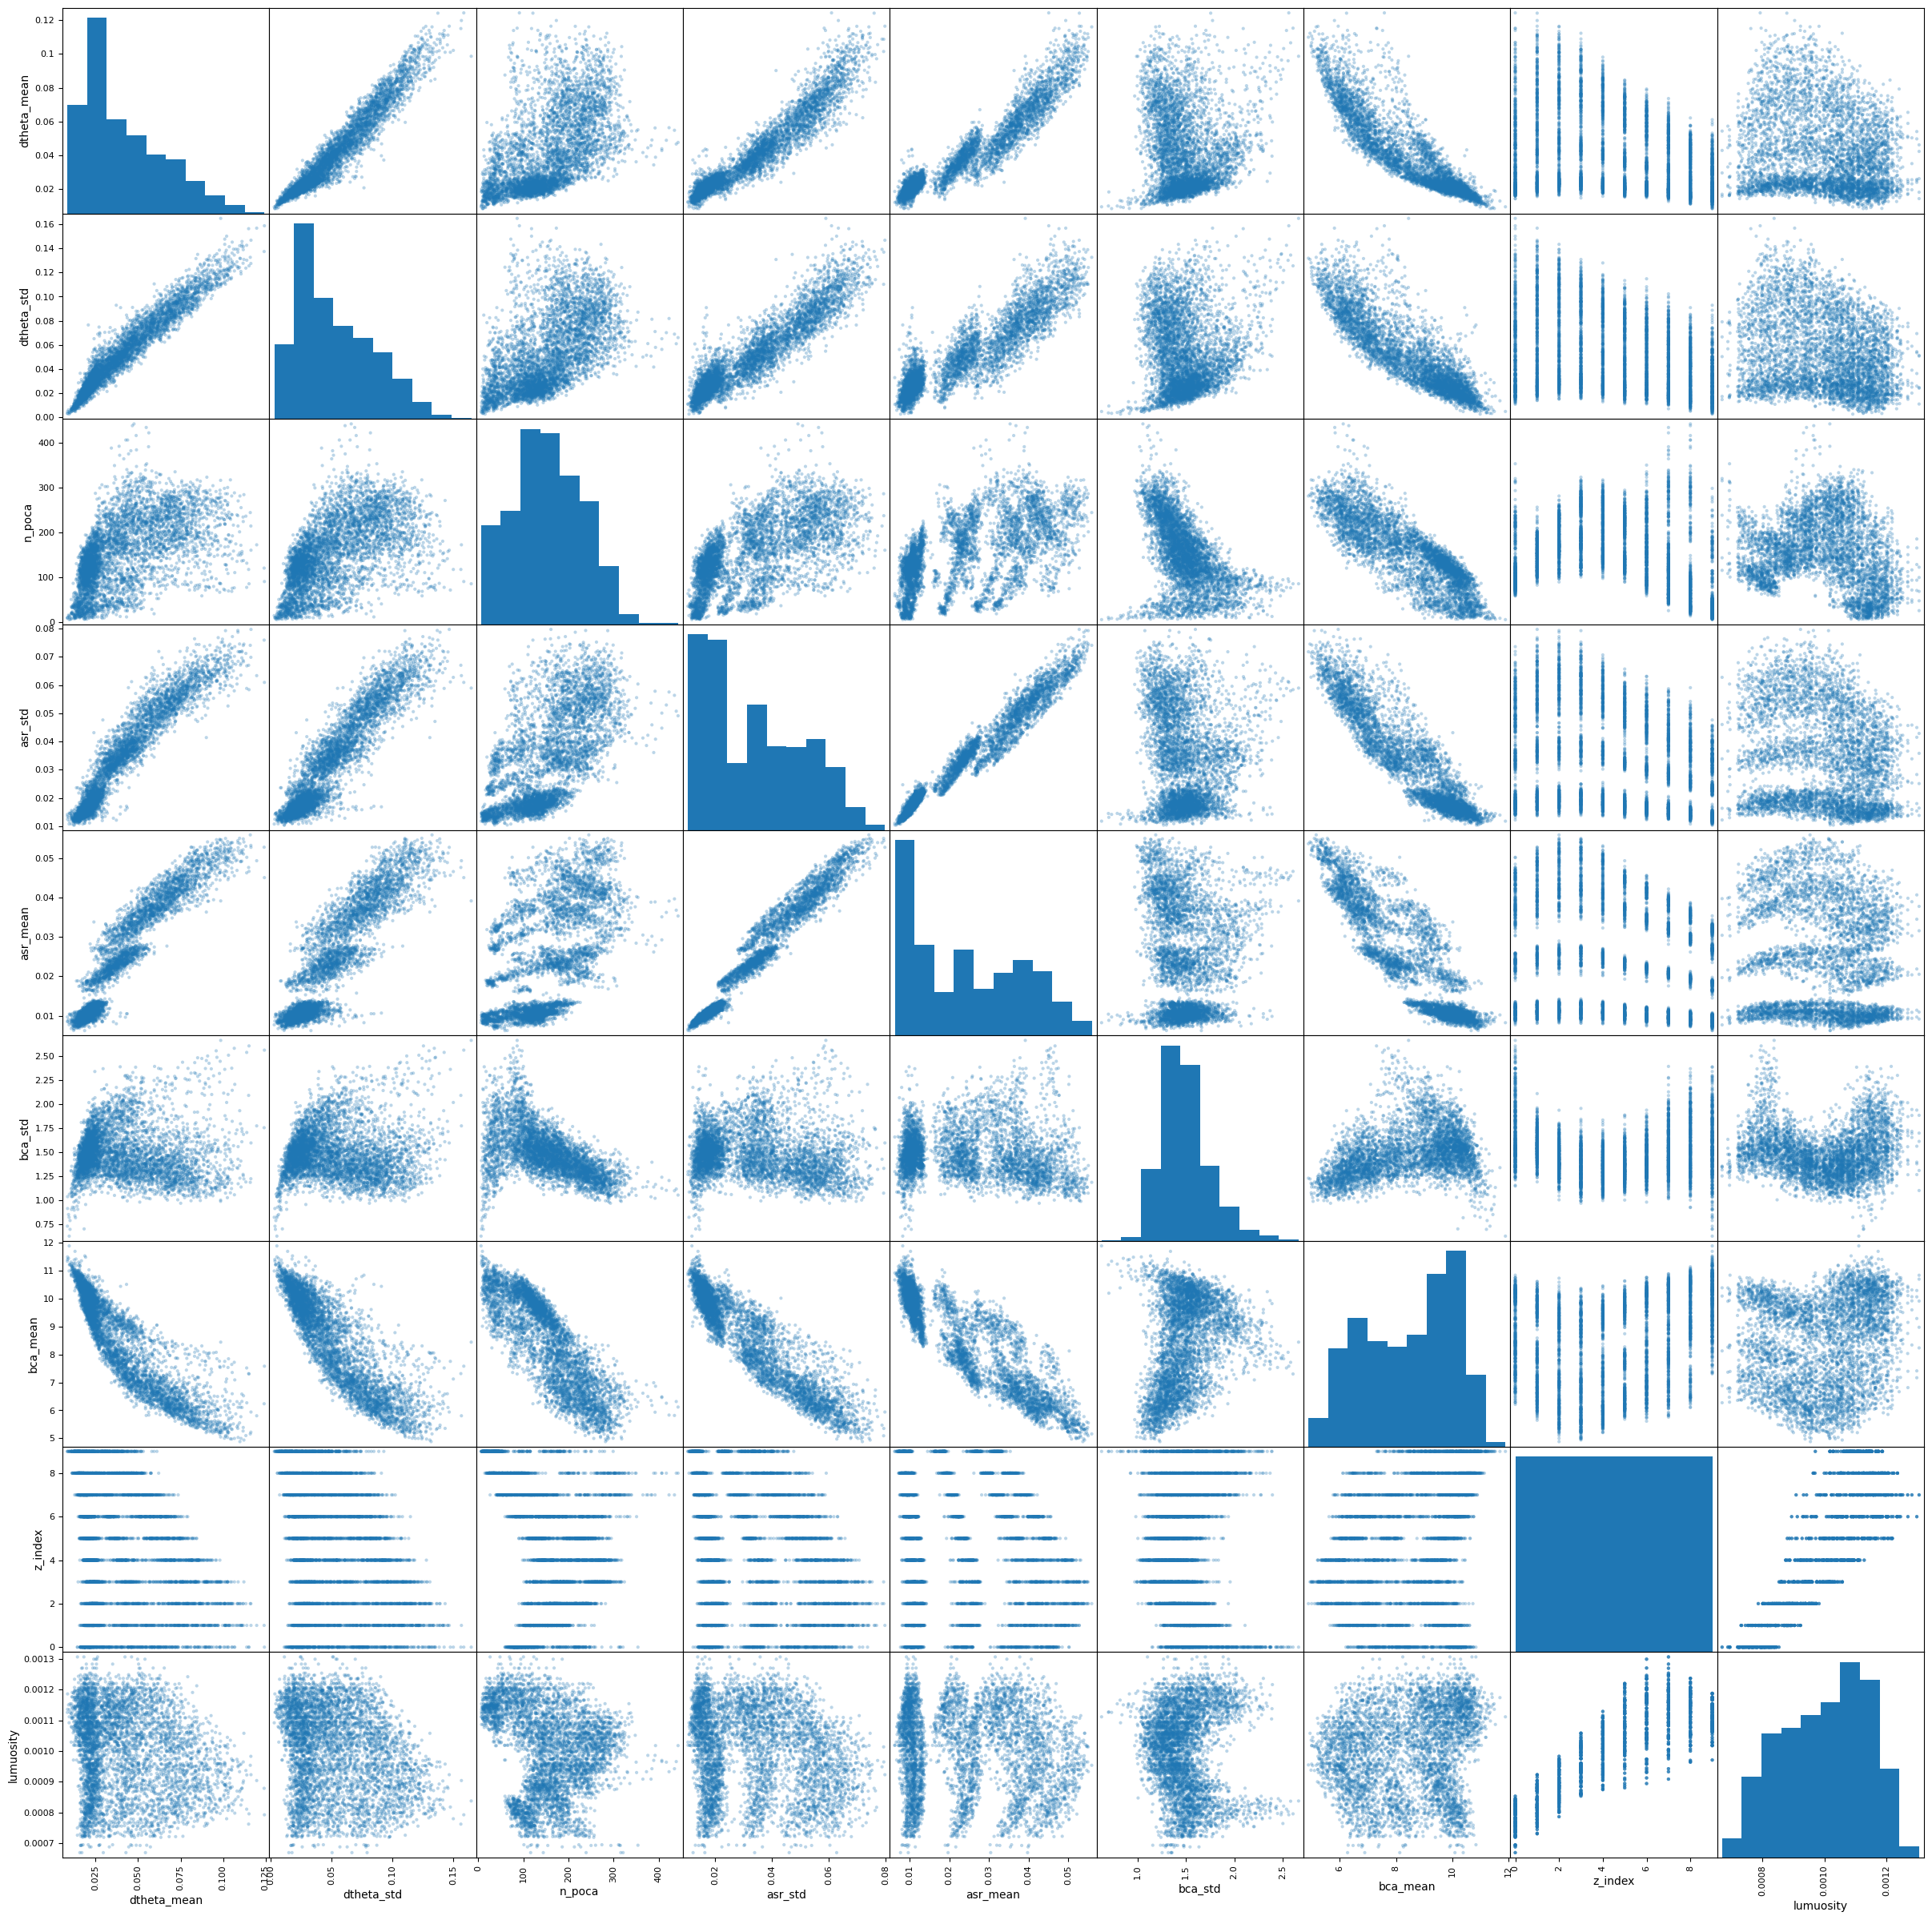

In [10]:
fig, ax = plt.subplots(figsize = (30, 30))

pd.plotting.scatter_matrix(frame = df.drop(columns = [
    "asr_q25", 
    "asr_q50", 
    "asr_q75", 
    "bca_q25", 
    "bca_q5", 
    "bca_q75", 
    "x_index", 
    "y_index"]), ax = ax, alpha = .3)

plt.savefig("../output/scatter_plot_1cm_voxel")

In [11]:
features = [
        "dtheta_mean", 
        "dtheta_std", 
        "n_poca", 
        "asr_std", 
        "asr_mean", 
        "asr_q25", 
        "asr_q50", 
        "asr_q75", 
        "bca_std",
        "bca_mean", 
        "bca_q25", 
        "bca_q5",
        "bca_q75",
        # "lumuosity",
        ]

**Standardize data**

In [12]:
from sklearn.preprocessing import StandardScaler
normalized_inputs = StandardScaler().fit_transform(df.loc[:, features].values)

**Run PCA**

In [13]:
from sklearn.decomposition import PCA

# Run PCA with 2 eigenvectors
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_inputs)

# Export as DataFrame
df_pca = pd.DataFrame(data = pca_data, columns = ["pc_1", "pc_2"])

**Interpreting the data**

In [14]:
print("Eigenvector pc1 accounts for {:.2f} % of the information".format(pca.explained_variance_ratio_[0]*100))
print("Eigenvector pc2 accounts for {:.2f} % of the information".format(pca.explained_variance_ratio_[1]*100))

Eigenvector pc1 accounts for 82.43 % of the information
Eigenvector pc2 accounts for 11.93 % of the information


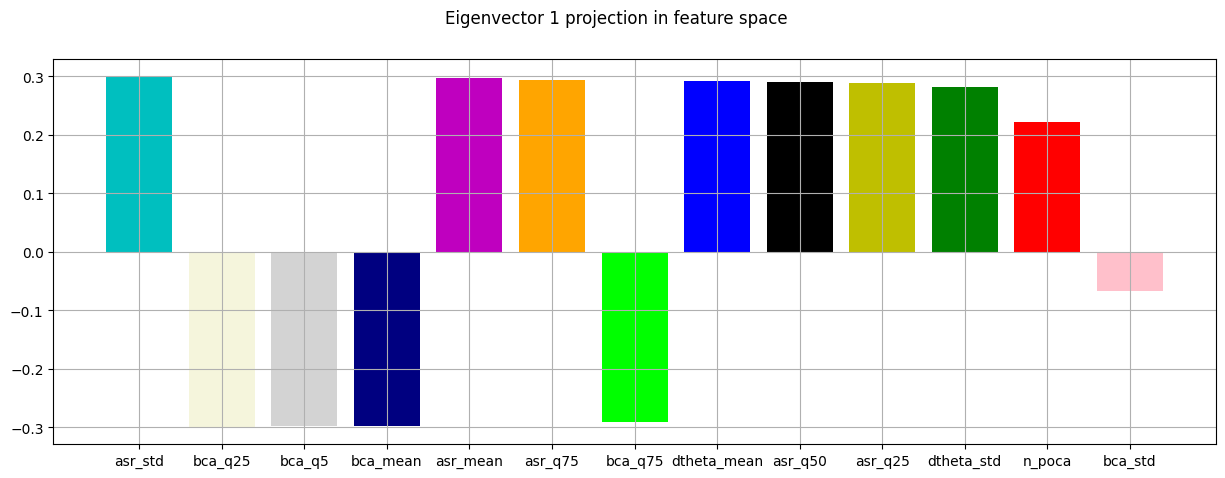

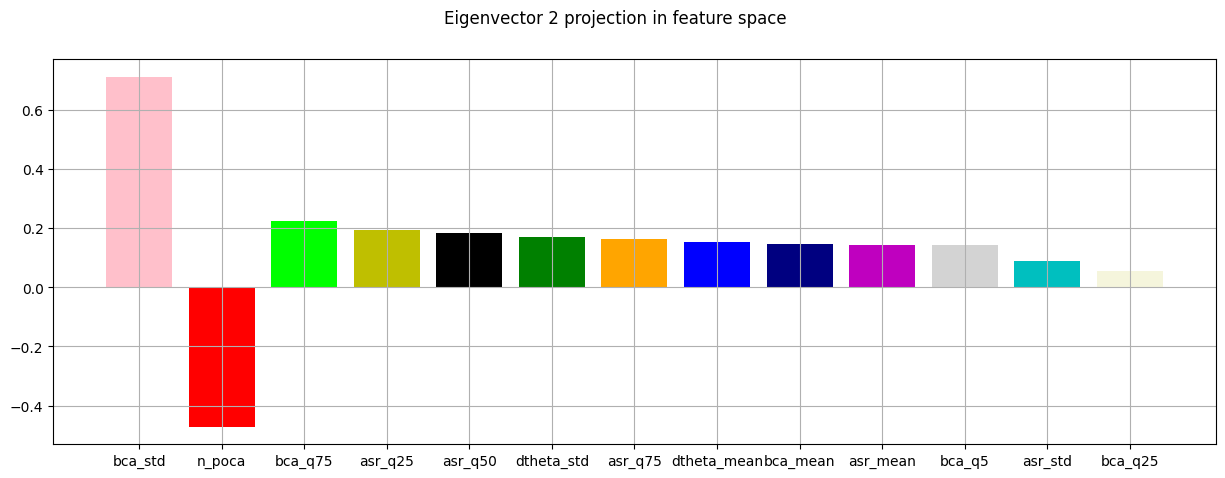

In [15]:
# Get the 2 eigenvectors
pca1, pca2 = pca.components_

eigen_1, eigen_2 = {}, {}
for feature, ev1, ev2 in zip(features, pca1, pca2):
    eigen_1[feature] = ev1
    eigen_2[feature] = ev2

eigen_1 = {key: value for key, value in sorted(eigen_1.items(), key = lambda item: -abs(item[1]))}
eigen_2 = {key: value for key, value in sorted(eigen_2.items(), key = lambda item: -abs(item[1]))}

# assign color to each feature
colors = {}
for feature, c in zip(features, ("b", "g", "r", "c", "m", "y", "k", "orange", "pink", "navy", "beige", "lightgray", "lime", "purple")):
    colors[feature] = c


fig, ax = plt.subplots(figsize = (15, 5))
fig.suptitle("Eigenvector 1 projection in feature space")
for key, value in zip(eigen_1.keys(), eigen_1.values()):
    ax.bar(key, value, color = colors[key])

ax.grid("on")
plt.savefig("pc1_eigenvalues")

fig, ax = plt.subplots(figsize = (15, 5))
fig.suptitle("Eigenvector 2 projection in feature space")
for key, value in zip(eigen_2.keys(), eigen_2.values()):
    ax.bar(key, value, color = colors[key])
ax.grid("on")
plt.savefig("pc2_eigenvalues")


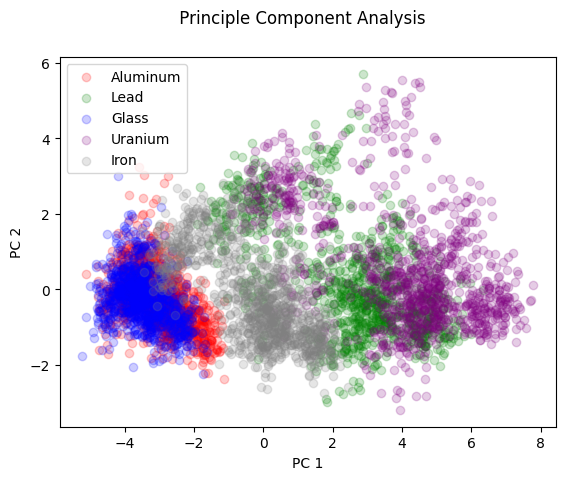

In [17]:
fig, ax = plt.subplots()
fig.suptitle(" Principle Component Analysis")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

targets = [
    'Aluminum', 
    'Lead', 
    'Glass', 
    'Uranium', 
    'Iron'
           ]

colors = [
    "red", 
    "green", 
    "blue", 
    "purple", 
    "grey"
          ]
for target, color in zip(targets, colors):

    indicesToKeep = (df['material'] == target) 
    ax.scatter(df_pca.loc[indicesToKeep, 'pc_1'], 
               df_pca.loc[indicesToKeep, 'pc_2'], 
               c = color, 
               label = target, 
               alpha = .2)
    
ax.legend()
plt.savefig("PCA")